In [1]:
import numpy as np
import torch
from torchvision import transforms, datasets
from torch import nn, optim
from IPython import display
import torchvision.utils as vutils
from matplotlib import pyplot as plt


In [2]:
dir =  './'
batch_size = 100

In [3]:
def download_mnist(dir):
  compose = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([1/2],[1/2])
  ])
  tvdataset = datasets.MNIST(root=dir,train=True,transform = compose,download=True)
  return tvdataset

In [4]:
##Download MNIST
data = download_mnist(dir)

In [5]:
#Creating Dataloder to iterate 
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,shuffle=True)
num_batches = len(data_loader)
print("Number of Batches = {}".format(num_batches))

Number of Batches = 600


In [6]:
class DiscriminatorNetwork(torch.nn.Module):
  """
  A two hidden later dicriminator NN
  """

  def __init__(self):
    super(DiscriminatorNetwork,self).__init__()
    num_features = 784
    num_outs = 1

    self.hidden_layer_0 = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.LeakyReLU(0.3),
        nn.Dropout(0.3)
    )

    self.hidden_layer_1 = nn.Sequential(
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.3),
        nn.Dropout(0.3)
    )
     
    
    self.out =  nn.Sequential(
        nn.Linear(512, num_outs),
        nn.Sigmoid()
    )
  
  def forward(self,x):
    x = self.hidden_layer_0(x)
    x = self.hidden_layer_1(x)
    x = self.out(x)
    return x

In [7]:
discriminator = DiscriminatorNetwork()

In [8]:
class GeneratorNetwork(torch.nn.Module):
  """
  A two hidden later GeneratorNetwork NN
  """

  def __init__(self):
    super(GeneratorNetwork,self).__init__()
    num_features = 100
    num_outs = 784

    self.hidden_layer_0 = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.LeakyReLU(0.3),
        nn.Dropout(0.3)
    )

    self.hidden_layer_1 = nn.Sequential(
        nn.Linear(256, 512),
        nn.LeakyReLU(0.3),
        nn.Dropout(0.3)
    )
     
   
    self.out =  nn.Sequential(
        nn.Linear(512, num_outs),
        nn.Tanh()
    )
  
  def forward(self,x):
    x = self.hidden_layer_0(x)
    x = self.hidden_layer_1(x)
    x = self.out(x)
    return x

In [9]:
generator = GeneratorNetwork()

In [10]:
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [11]:
print(discriminator)

DiscriminatorNetwork(
  (hidden_layer_0): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden_layer_1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.3, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [12]:
print(generator)

GeneratorNetwork(
  (hidden_layer_0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden_layer_1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.3, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=784, bias=True)
    (1): Tanh()
  )
)


In [13]:
def generate_noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [14]:
#Define BCE loss
loss = nn.BCELoss()

# Numbers of steps after which to update discriminator
d_steps = 1 # Goodfellow et. al 2014 mention this in his paper

# Number of epochs
num_epochs = 50

In [15]:
from torch.autograd.variable import Variable

def real_output(size):
  """
  Creates target output for calculating Loss 
  """
  data = Variable(torch.ones(size,1))
  if torch.cuda.is_available():
    return data.cuda()
  else:
    return data

def fake_output(size):
  """
  Creates target output for calculating Loss 
  """
  data = Variable(torch.zeros(size,1))
  if torch.cuda.is_available():
    return data.cuda()
  else:
    return data
  

In [16]:
lr = 0.0004
descriminator_optimizer = optim.Adam(discriminator.parameters(), lr = lr)
generator_optimizer = optim.Adam(generator.parameters(), lr = lr)

def train_discriminator(descriminator_optimizer, real_data, fake_data, batch_size):

  ##In PyTorch , we need to set the gradients to zero before starting to do backpropragation 
  ##because PyTorch accumulates the gradients on subsequent backward passes.
  descriminator_optimizer.zero_grad()

  ##Prediction on real data
  prediction_real = discriminator(real_data)

  ##Calculate error and backpropagate
  error_real = loss(prediction_real, real_output(batch_size))
  error_real.backward()

  ##Prediction on fake data
  prediction_fake = discriminator(fake_data)
  error_fake = loss(prediction_fake, fake_output(batch_size))
  error_fake.backward()

  ##update weights with gradients
  descriminator_optimizer.step()

  return error_real + error_fake , prediction_real, prediction_fake



In [17]:
def train_generator(generator_optimizer, fake_data, batch_size):

  generator_optimizer.zero_grad()

  prediction = discriminator(fake_data)
  error = loss(prediction,real_output(batch_size))
  error.backward()

  generator_optimizer.step()

  # we will use this loss for printing
  return error

In [18]:
num_test_samples = 8
test_noise = generate_noise(num_test_samples)

In [19]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [20]:
def display_images(images, num_images, format='NCHW', normalize=True,plot_horizontal=True):
    '''
    input images are expected in format (NCHW)
    '''
    if type(images) == np.ndarray:
        images = torch.from_numpy(images)
    
    if format=='NHWC':
        images = images.transpose(1,3)
    
    # Make horizontal grid from image tensor
    horizontal_grid = vutils.make_grid(
        images, normalize=normalize, scale_each=True)
    
    # Plot it
    fig = plt.figure(figsize=(16, 16))
    plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
    plt.axis('off')
    if plot_horizontal:
        display.display(plt.gcf())
    plt.close()
    



Current Epoch = 49/50 : Current Batch = 500/600


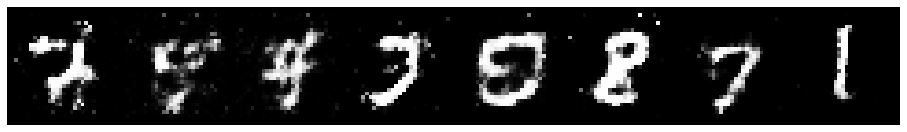

Discriminator Loss = 0.796 : Generator Loss = 1.472
Mean D(x) Real : 0.757, Mean D(G(z)) Fake : 0.298


In [21]:
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        #Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): 
          real_data = real_data.cuda()
        batch_size = real_data.size(0)

        # Generate fake data
        fake_data = generator(generate_noise(batch_size)).detach()
        # Train discriminator
        d_error, d_prediction_real, d_prediction_fake = train_discriminator(descriminator_optimizer,
                                                                real_data, 
                                                                fake_data,
                                                                batch_size)

        #Train Generator
        # Generate fake data
        fake_data = generator(generate_noise(batch_size))
        # Train Generator
        g_error = train_generator(generator_optimizer, 
                                  fake_data,
                                  batch_size)

        if n_batch%100 == 0:
            display.clear_output(True)
            print("Current Epoch = {}/{} : Current Batch = {}/{}".format(epoch,num_epochs,n_batch,num_batches))
            ##print(d_error, g_error, epoch, n_batch, num_batches)
            ## Generate test images using generator
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            display_images(test_images, num_test_samples, format='NCHW', normalize=True)
            print("Discriminator Loss = {:.3f} : Generator Loss = {:.3f}".format(d_error,g_error,))
            print("Mean D(x) Real : {:.3f}, Mean D(G(z)) Fake : {:.3f}".format(d_prediction_real.mean(),d_prediction_fake.mean()))


In [26]:
torch.save(generator.state_dict(),
                   './gen',)
torch.save(discriminator.state_dict(),
                   './dis',)

In [ ]:
"""
References
https://github.com/andersy005/deep-learning
https://github.com/diegoalejogm/gans
"""

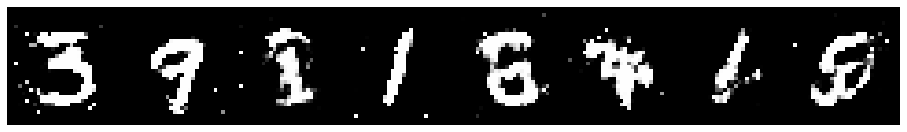

In [52]:
test_noise = generate_noise(num_test_samples)

for i in range(0,100):
    test_noise = test_noise + .30*generate_noise(num_test_samples)
    display.clear_output(True)
    test_images = vectors_to_images(generator(test_noise)).data.cpu()
    display_images(test_images, num_test_samples, format='NCHW', normalize=True)


tensor([[-5.4064e-01, -5.5841e-01,  1.9203e+00, -6.3982e-01,  1.5371e+00,
          6.8297e-01,  1.0150e+00,  5.2402e-01, -8.5236e-01,  7.8860e-01,
          6.2519e-01, -1.0498e+00, -9.9833e-01,  1.2477e-01,  2.2406e-01,
          1.2606e+00, -6.9056e-01,  4.1747e-01,  7.5366e-01,  9.3441e-01,
         -4.7071e-01, -7.2464e-01,  1.8185e+00,  1.2749e-01,  3.9096e-01,
         -5.3306e-01, -2.1313e+00, -9.9550e-01,  8.9017e-01, -2.9924e-01,
         -1.5169e+00, -7.9386e-01,  5.5480e-01,  2.2990e+00, -1.0903e+00,
         -1.6944e+00, -2.4437e-01,  1.5657e+00,  7.1843e-01,  8.9294e-01,
          2.8696e+00,  2.9135e-01, -8.2538e-01, -1.0753e+00, -1.5658e+00,
         -4.5656e-02, -7.0524e-02,  6.5745e-04, -1.3729e-01, -4.3946e-02,
          9.2000e-02,  1.3331e+00,  5.4028e-01,  4.5659e-01, -3.4251e-01,
         -2.3395e-01,  5.3851e-01,  5.2924e-01, -9.6274e-01, -1.7158e+00,
          1.9343e+00, -2.0539e-01, -4.7470e-01,  1.6901e+00, -4.3177e-01,
          5.7699e-01,  5.8577e-01, -7.